In [ ]:
# Imports

SELECT | created_dt_tm, prsnl_id, fqn, num, den

FROM | PH_F_Scorecard_Trending_Personnel_Point

WHERE |
    den > 0,
    date between month 1 and month 3
    date_count >=3

Add Registry & Measure

In [1]:
from Ian import client_functions, pd, np, clusters, equal_in, Benchmarks
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style 
import PandasToPowerPoint as p2p # make PowerPoints
from pptx.enum.dml import MSO_THEME_COLOR # color text based on PPT theme
from pptx.util import Inches, Pt # add Inches for sizing PPT elements
from pptx.enum.text import PP_ALIGN # for aligning text
from pptx.enum.text import MSO_ANCHOR # for anchoring text in table

In [2]:
pd.options.display.max_columns=200
pd.options.display.max_rows=1000
pd.options.display.max_colwidth=500

# A. Table & Analysis

## 1. Data Cleaning

In [3]:
client = 'LGMC_LA'

Run the Client Benchmarks AutoPPT [Link](https://github.cerner.com/ConsultingAnalytics/Pop-Health-Consulting-Analytics/blob/master/DataInsights/ABC/Client%20Benchmarks%20AutoPPT%20Template.ipynb) and download the csv locally

Node 54 > Python > Alex

In [4]:
# past filepath of csv from "Client Benchmarks AutoPPT Template.ipynb"
path = rf"C:\Users\ao054198\Downloads\LGMC_LA_scorable_raw_data_2019Q2.csv"
raw = pd.read_csv(path,encoding = "ISO-8859-1")
raw.columns = raw.columns.str.lower()

In [5]:
raw.head(1)

,year_quarter,fully_qualified_name,registry,measure,date,prsnl_id,numerator,denominator
0,2019Q2,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,2019-04-03 01:10:38.959000-05:00,35587ab3-069c-4dc6-8da1-6b0a98b6025e,119,188


In [6]:
# for 3 months in specified querter, put 1st date of each into an array
dates = Benchmarks.dream_dates(raw.year_quarter.unique()[0])

In [7]:
dates

DatetimeIndex(['2019-04-01', '2019-05-01', '2019-06-01'], dtype='datetime64[ns]', freq='MS')

In [8]:
scorable = raw[[
    "date",
    "prsnl_id",
    "fully_qualified_name",
    "numerator",
    "denominator"
]]

In [9]:
# ensure num and den are numeric
# same as scorable[["numerator","denominator"]] = scorable[["numerator","denominator"]].apply(pd.to_numeric)
scorable.loc[:, 'numerator':] = scorable.loc[:, 'numerator':].apply(pd.to_numeric).copy()

C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
df = scorable

In [11]:
df.date = pd.to_datetime(pd.to_datetime(df.date, utc=True).dt.date)

C:\Users\ao054198\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
# # date check if more than 3 dates; keep earliest for each month
df = Benchmarks.date_check(df,dates)

In [13]:
df.date.unique()

array(['2019-04-03T00:00:00.000000000', '2019-05-02T00:00:00.000000000',
       '2019-06-02T00:00:00.000000000'], dtype='datetime64[ns]')

## 2. ABC Calculation

In [14]:
# make abc 90
abc90 = Benchmarks.abc(Benchmarks.population(Benchmarks.apf(df.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean()), ratio = 0.1))

In [15]:
# make abc 50
abc50 = Benchmarks.abc(Benchmarks.population(Benchmarks.apf(df.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean()), ratio = 0.5))

In [16]:
# join them
abc = abc90.join(abc50, lsuffix = '_90', rsuffix = '_50')

In [17]:
# calculate avg MM for each prsnl_id for each fqn
s = df.groupby([
    'fully_qualified_name',
    'prsnl_id'
])[[
    'numerator',
    'denominator'
]].mean().apply(lambda x : x['numerator'] / x['denominator'], axis = 1)

In [18]:
#creating a df for tier 1, empty
tiers = pd.DataFrame(index = s.index.get_level_values('fully_qualified_name').unique(), columns = [
    'tier3'
])
# join to abc
tiers = tiers.join(abc)

In [19]:
#Benchmarks.tiers function is where tier 3 is getting created
for fqn in s.index.get_level_values('fully_qualified_name').unique():
    tiers.loc[fqn, 'tier3'] = Benchmarks.tiers(s.loc[fqn])

In [20]:
# rename columns to reflect tiers
tiers = tiers[[
    'tier3',
    'abc_50',
    'abc_90'
]].rename(columns = {
    'abc_50' : 'tier2',
    'abc_90' : 'tier1'
})

## 3. Determine Which Tiers Prsnl_Id Fall Into

In [21]:
# join the prsnl_id MM to the QualiTiers
st = s.reset_index('prsnl_id').join(tiers).rename(columns = {
    0 : 'measure_met'
})

In [22]:
# classify prsnl_id by their tier
st['tier'] = np.where(st.measure_met >= st.tier1, 'tier1', np.where(st.measure_met >= st.tier2, 'tier2', np.where(st.measure_met >= st.tier3, 'tier3', 'bottom')))

In [23]:
# make bottom ABC be 0
tiers['bottom'] = 0

In [24]:
# Count prsnl in each of the Tiers
st = st.groupby([
    'fully_qualified_name',
    'tier'
]).agg({
    'prsnl_id' : pd.Series.nunique
}).rename(columns = {
    'prsnl_id' : 'prsnl_count'
}).stack().unstack('tier').reset_index(1, drop = True).fillna(0)

In [25]:
# stack tiers df
tiers = tiers.stack().to_frame('values')

In [26]:
# stack the prsnl_count dataframe
st = st.stack().to_frame('prsnl_count')

In [27]:
tiers.index.rename('tier', level = 1, inplace = True)

## 4. Stack Prsnl counts and Tiers

In [28]:
# join prsnl_counts & tier values
formatted_df = st.join(tiers).reset_index()
# join measure from raw_df
formatted_df = formatted_df.merge(raw[["fully_qualified_name","registry","measure"]])
# format as int and percent
formatted_df['values'] = ((formatted_df['values']).astype(float)*100).round(1).astype(str) + '%'
formatted_df['prsnl_count'] = (formatted_df['prsnl_count']).astype(int)
# remove duplicate rows
formatted_df.drop_duplicates(inplace=True)

In [29]:
# rearrange columns
f_df = formatted_df[[
    "fully_qualified_name",
    "registry",
    "measure",
    "tier",
    "prsnl_count",
    "values"
]]

In [30]:
f_df.head(1)

,fully_qualified_name,registry,measure,tier,prsnl_count,values
0,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,bottom,35,0.0%


## 5. Export to CSV

In [31]:
f_df.to_csv(f'{client}_Formatted_Benchmarks.csv', index=False)
# test format
pd.read_csv(f'{client}_Formatted_Benchmarks.csv',encoding = "ISO-8859-1").head(6)

,fully_qualified_name,registry,measure,tier,prsnl_count,values
0,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,bottom,35,0.0%
1,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,tier1,1,83.2%
2,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,tier2,13,74.7%
3,cernerstandard.adultwellness.org2014.clinical/breast-cancer-screening,Adult Wellness,Breast Cancer Screening,tier3,8,68.3%
4,cernerstandard.adultwellness.org2014.clinical/colorectal-cancer-screening,Adult Wellness,Colorectal Cancer Screening,bottom,91,0.0%
5,cernerstandard.adultwellness.org2014.clinical/colorectal-cancer-screening,Adult Wellness,Colorectal Cancer Screening,tier1,16,75.6%


## 6. Plot Chart

### format table

In [32]:
# join tiers and prsnl_counts df
st = st.join(tiers).unstack().stack(0).sort_index(level = [0,1], ascending = [True, False])
# make numeric
st = st.apply(pd.to_numeric)
# reorder
st = st[['bottom', 'tier3', 'tier2', 'tier1']]

### format visual styles

In [33]:
style.use('fivethirtyeight')

cerner_colors = [
    '#0d94d2', # Blue
    '#7bc143', # Green
    '#6a737b', # Grey
    '#4bb8ef', # Cyan
    '#7c2b83', # Purple
    '#f58025', # Orange
    '#fdb913'  # Yellow
]

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cerner_colors)

%matplotlib inline

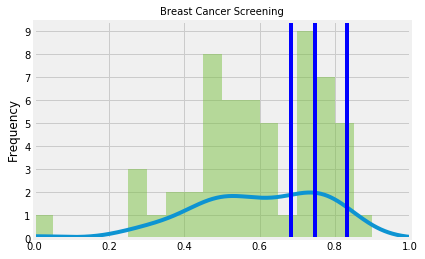

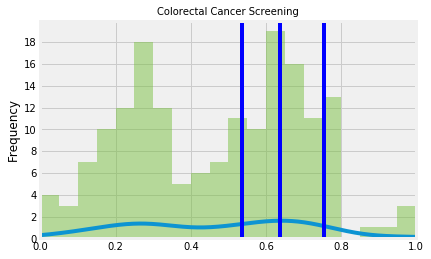

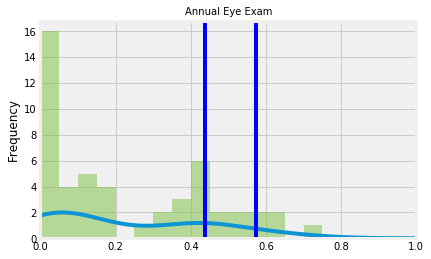

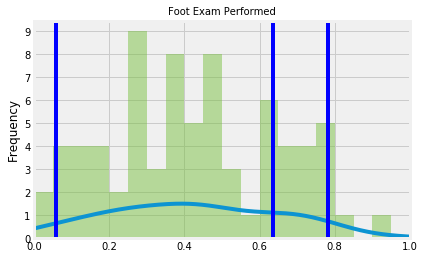

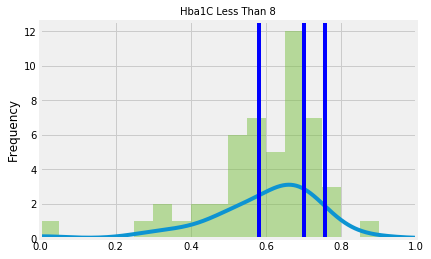

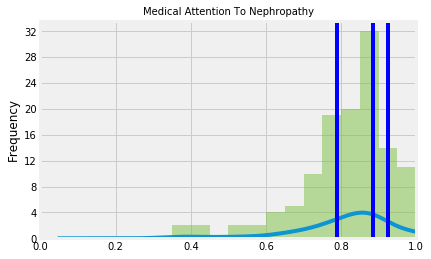

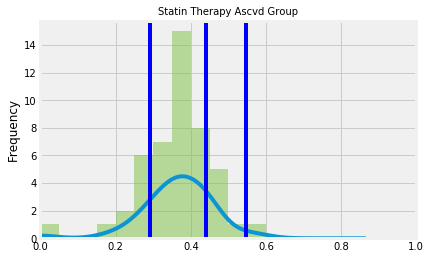

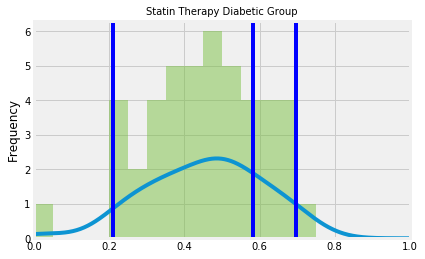

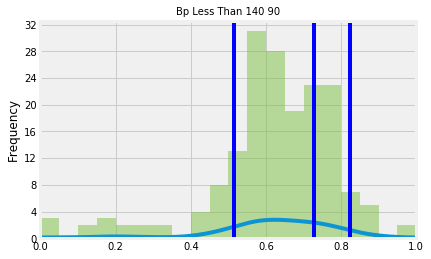

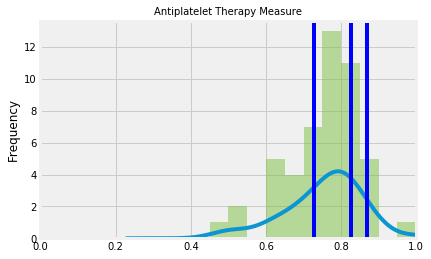

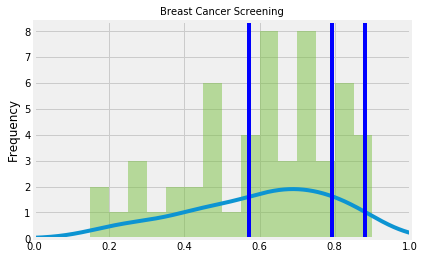

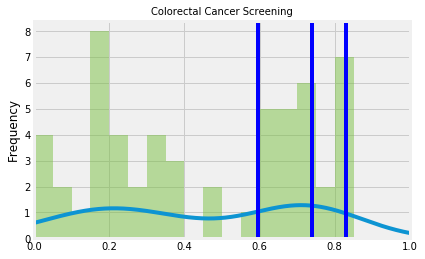

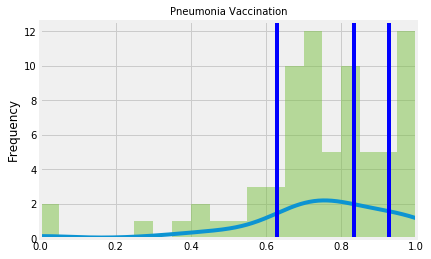

In [34]:
for fqn in s.index.get_level_values('fully_qualified_name').unique():
    ax = Benchmarks.tier_plot(s.loc[fqn], 
                              st.loc[(fqn, 'values'), 'tier1'], 
                              st.loc[(fqn, 'values'), [
        'tier2',
        'tier3'
    ]], 
        title=fqn.rsplit('/',1)[-1].replace("-"," ").title())

# B. Powerpoint Automation

## 1. Formatting

In [35]:
# assign codes for PPT Table Formatting
medium_3_accent_5 = "{74C1A8A3-306A-4EB7-A6B1-4F7E0EB9C5D6}"
no_style_no_grid = "{2D5ABB26-0587-4C30-8999-92F81FD0307C}"

## 2. Make Slide For One Measure (Test Small Changes)

In [36]:
# pick the fqn which determines the Registry & Measure
fqn = f_df.head(1).fully_qualified_name[0]
reg = f_df.loc[f_df.fully_qualified_name==fqn].registry[0]
meas = f_df.loc[f_df.fully_qualified_name==fqn].measure[0]

In [37]:
# open pptx from Cerner Standard Template
prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Ian\PowerPoint Templates\Cerner Standard v3.pptx".replace('\\','/'))

######################
## CREATE NEW SLIDE ##
######################

# save slide from layout 9 in Slide Master
primary_content = prs.slide_layouts[1]

# add slide
slide = prs.slides.add_slide(primary_content)

# Make table in background
f_new = f_df.loc[f_df.fully_qualified_name==fqn]

##################
## TITLE & TEXT ##
##################

# select title box
title_box = slide.shapes[0]
text_frame = title_box.text_frame
p = text_frame.paragraphs[0]

# add registry, then bold & color
run = p.add_run()
run.text = reg
font = run.font
font.bold = True
font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

# add measure
run = p.add_run()
run.text = " "+f_new.measure.unique()[0]
font = run.font

####################
## PROVIDER TABLE ##
####################

#### Create Table ####

shapes = slide.shapes

table_placeholder = slide.shapes[2]
shape = table_placeholder.insert_table(rows=11, cols=1)
table = shape.table

#### Insert dynamic values ####

cell = table.cell(1, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier1'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
font = run.font
font.size = Pt(28)
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## TIER
# select cell text
cell = table.cell(2, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = "Tier 1: "
font = run.font
font.size = Pt(24)
font.bold = True
# add bold & blue percent
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
font = run.font
font.bold = True
font.size = Pt(24)
font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## PROVIDERS
cell = table.cell(4, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier2'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
font = run.font
font.size = Pt(28)
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## TIER
# select cell text
cell = table.cell(5, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = "Tier 2: "
font = run.font
font.size = Pt(24)
font.bold = True
# add bold & blue percent
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
font = run.font
font.bold = True
font.size = Pt(24)
font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## PROVIDERS
cell = table.cell(7, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier3'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
font = run.font
font.size = Pt(28)
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## TIER
# select cell text
cell = table.cell(8, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = "Tier 3: "
font = run.font
font.size = Pt(24)
font.bold = True
# add bold & blue percent
run = p.add_run()
run.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
font = run.font
font.bold = True
font.size = Pt(24)
font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

## PROVIDERS
cell = table.cell(10, 0)
p = cell.text_frame.paragraphs[0]
# add the tier name in bold
run = p.add_run()
run.text = f_new.loc[f_new.tier=='bottom'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
font = run.font
font.size = Pt(28)
# center and middle text
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.vertical_anchor = MSO_ANCHOR.MIDDLE

# format table style
tbl =  shape._element.graphic.graphicData.tbl
style_id = no_style_no_grid
tbl[0][-1].text = style_id

##################
## TARGET TABLE ##
##################

table_placeholder = slide.shapes[3]
shape = table_placeholder.insert_table(rows=3, cols=4)
table = shape.table
cell = table.cell(0, 0)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = 'Method'
cell = table.cell(0, 1)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = 'Tier 3'
cell = table.cell(0, 2)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = 'Tier 2'
cell = table.cell(0, 3)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = 'Tier 1'
cell = table.cell(1, 0)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
cell.text = 'Scorecard Target'
cell = table.cell(2, 0)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
cell.text = 'QualiTiers'
cell = table.cell(1, 1)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = '-'
cell = table.cell(1, 2)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = '-'
cell = table.cell(1, 3)
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell.text = '-'

# insert dynamic values
cell = table.cell(2, 1)
cell.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell = table.cell(2, 2)
cell.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
cell = table.cell(2, 3)
cell.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

# format table style
tbl =  shape._element.graphic.graphicData.tbl
style_id = medium_3_accent_5
tbl[0][-1].text = style_id

#######################
## QualiTiers Visual ##
#######################
ax = Benchmarks.tier_plot(s.loc[fqn], 
                          st.loc[(fqn, 'values'), 'tier1'], 
                          st.loc[(fqn, 'values'), [
    'tier2',
    'tier3'
]], 
    title=fqn.rsplit('/',1)[-1].replace("-"," ").title())

ax.savefig
ax.savefig('test_fig.png', dpi = 500)
#             close fig
plt.close(ax)
# insert picture
slide.shapes[1].insert_picture('test_fig.png')

##########
## SAVE ##
##########
# save pptx
prs.save(f"{client}_One_Measure_QualiTiers.pptx")
print(f"Finished {reg},{meas}")
print("Done!")

Finished Adult Wellness,Breast Cancer Screening
Done!


# All Measures Test

In [38]:
# open pptx from Cerner Standard Template
prs = p2p.Presentation(r"\\mustang\workops_pub\Pop Health\DataWorks\Data Insights\Personal Working Folders\Ian\PowerPoint Templates\Cerner Standard v3.pptx".replace('\\','/'))

# Loop through each measure in each registry
for fqn in f_df.fully_qualified_name.unique():
        if fqn != 'All':
            
            ######################
            ## CREATE NEW SLIDE ##
            ######################

            # save slide from layout 9 in Slide Master
            primary_content = prs.slide_layouts[1]

            # add slide
            slide = prs.slides.add_slide(primary_content)

            # Make table in background
            f_new = f_df.loc[f_df.fully_qualified_name==fqn]

            ##################
            ## TITLE & TEXT ##
            ##################
    
            # select title box
            title_box = slide.shapes[0]
            text_frame = title_box.text_frame
            p = text_frame.paragraphs[0]
            
            # make dynamic reg & meas
            reg = f_new.registry.unique()[0]
            meas = f_new.measure.unique()[0]
            # add registry, then bold & color
            run = p.add_run()
            run.text = f_new.registry.unique()[0]
            font = run.font
            font.bold = True
            font.color.theme_color = MSO_THEME_COLOR.ACCENT_1

            # add measure
            run = p.add_run()
            run.text = " "+f_new.measure.unique()[0]
            font = run.font

            ####################
            ## PROVIDER TABLE ##
            ####################

            #### Create Table ####

            shapes = slide.shapes

            table_placeholder = slide.shapes[2]
            shape = table_placeholder.insert_table(rows=11, cols=1)
            table = shape.table

            #### Insert dynamic values ####

            cell = table.cell(1, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier1'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
            font = run.font
            font.size = Pt(28)
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## TIER
            # select cell text
            cell = table.cell(2, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = "Tier 1: "
            font = run.font
            font.size = Pt(24)
            font.bold = True
            # add bold & blue percent
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
            font = run.font
            font.bold = True
            font.size = Pt(24)
            font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## PROVIDERS
            cell = table.cell(4, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier2'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
            font = run.font
            font.size = Pt(28)
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## TIER
            # select cell text
            cell = table.cell(5, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = "Tier 2: "
            font = run.font
            font.size = Pt(24)
            font.bold = True
            # add bold & blue percent
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
            font = run.font
            font.bold = True
            font.size = Pt(24)
            font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## PROVIDERS
            cell = table.cell(7, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier3'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
            font = run.font
            font.size = Pt(28)
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## TIER
            # select cell text
            cell = table.cell(8, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = "Tier 3: "
            font = run.font
            font.size = Pt(24)
            font.bold = True
            # add bold & blue percent
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
            font = run.font
            font.bold = True
            font.size = Pt(24)
            font.color.theme_color = MSO_THEME_COLOR.ACCENT_1
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            ## PROVIDERS
            cell = table.cell(10, 0)
            p = cell.text_frame.paragraphs[0]
            # add the tier name in bold
            run = p.add_run()
            run.text = f_new.loc[f_new.tier=='bottom'][["prsnl_count"]].iloc[0,0].astype(str)+" Providers"
            font = run.font
            font.size = Pt(28)
            # center and middle text
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.vertical_anchor = MSO_ANCHOR.MIDDLE

            # format table style
            tbl =  shape._element.graphic.graphicData.tbl
            style_id = no_style_no_grid
            tbl[0][-1].text = style_id

            ##################
            ## TARGET TABLE ##
            ##################

            table_placeholder = slide.shapes[3]
            shape = table_placeholder.insert_table(rows=3, cols=4)
            table = shape.table
            cell = table.cell(0, 0)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = 'Method'
            cell = table.cell(0, 1)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = 'Tier 3'
            cell = table.cell(0, 2)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = 'Tier 2'
            cell = table.cell(0, 3)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = 'Tier 1'
            cell = table.cell(1, 0)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
            cell.text = 'Scorecard Target'
            cell = table.cell(2, 0)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.LEFT
            cell.text = 'QualiTiers'
            cell = table.cell(1, 1)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = '-'
            cell = table.cell(1, 2)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = '-'
            cell = table.cell(1, 3)
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell.text = '-'

            # insert dynamic values
            cell = table.cell(2, 1)
            cell.text = f_new.loc[f_new.tier=='tier3'][["values"]].iloc[0,0]
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell = table.cell(2, 2)
            cell.text = f_new.loc[f_new.tier=='tier2'][["values"]].iloc[0,0]
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER
            cell = table.cell(2, 3)
            cell.text = f_new.loc[f_new.tier=='tier1'][["values"]].iloc[0,0]
            cell.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

            # format table style
            tbl =  shape._element.graphic.graphicData.tbl
            style_id = medium_3_accent_5
            tbl[0][-1].text = style_id

            #######################
            ## QualiTiers Visual ##
            #######################
            ax = Benchmarks.tier_plot(s.loc[fqn], 
                                      st.loc[(fqn, 'values'), 'tier1'], 
                                      st.loc[(fqn, 'values'), [
                'tier2',
                'tier3'
            ]], 
                title=fqn.rsplit('/',1)[-1].replace("-"," ").title())

            ax.savefig
            ax.savefig('test_fig.png', dpi = 500)
            #             close fig
            plt.close(ax)
            # insert picture
            slide.shapes[1].insert_picture('test_fig.png')

            ##########
            ## SAVE ##
            ##########
            # save pptx
            prs.save(f"{client}_QualiTiers.pptx")
            print(f"Finished {reg},{meas}")
print("Done!")

Finished Adult Wellness,Breast Cancer Screening
Finished Adult Wellness,Colorectal Cancer Screening
Finished Diabetes Mellitus,Annual Eye Exam
Finished Diabetes Mellitus,Foot Exam Performed
Finished Diabetes Mellitus,Hba1c Less Than 8
Finished Diabetes Mellitus,Medical Attention To Nephropathy
Finished Hyperlipidemia,Statin Therapy Ascvd Group
Finished Hyperlipidemia,Statin Therapy Diabetic Group
Finished Hypertension,Bp Less Than 140 90
Finished Ivdcad,Antiplatelet Therapy Measure
Finished Senior Wellness,Breast Cancer Screening
Finished Senior Wellness,Colorectal Cancer Screening
Finished Senior Wellness,Pneumonia Vaccination
Done!
